# Исследование надежности заемщиков.

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. 

Входные данные от банка — статистика о платёжеспособности клиентов.

Цель исследования - ответить на вопросы:
* Есть ли зависимость между количеством детей и возвратом кредита в срок?
* Есть ли зависимость между семейным положением и возвратом кредита в срок?
* Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
* Как разные цели кредита влияют на его возврат в срок?

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Обзор данных

In [320]:
#  импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


### Шаг 2 Выгрузка данных

In [321]:
data = pd.read_csv('data.csv') #выгружаем файл и оцениваем из чего он состоит
display(data.info()) 
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


None

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


В таблице 12 столбцов согласно документации:

* children — количество детей в семье
* days_employed — общий трудовой стаж в днях
* dob_years — возраст клиента в годах
* education — уровень образования клиента
* education_id — идентификатор уровня образования
* family_status — семейное положение
* family_status_id — идентификатор семейного положения
* gender — пол клиента
* income_type — тип занятости
* debt — имел ли задолженность по возврату кредитов
* total_income — ежемесячный доход
* purpose — цель получения кредита

Нарушений стиля названия столбцов не наблюдается. 

Разниться количество значений в столбцах, что говорит о пропусках данных. Проверим столбца days_employed и total_income, у них равное количество значений, в одинаковых ли строках пропущенны данные.

По столбцу education можно судить, что в столбце есть значения с разным регстром.

### Шаг 2.1 Заполнение пропусков

In [322]:
#проверка сколько пропусков находиться в столбцах
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [323]:
#  проверим в одинаковых ли строках пропущенны значения
data[data['days_employed'].isna()].all()==data[data['total_income'].isna()].all() 

children            True
days_employed       True
dob_years           True
education           True
education_id        True
family_status       True
family_status_id    True
gender              True
income_type         True
debt                True
total_income        True
purpose             True
dtype: bool

In [324]:
#вычислим процент пропусков относительно общего количества данных в столбцах
data.isna().sum()/data.shape[0]

children            0.000000
days_employed       0.100999
dob_years           0.000000
education           0.000000
education_id        0.000000
family_status       0.000000
family_status_id    0.000000
gender              0.000000
income_type         0.000000
debt                0.000000
total_income        0.100999
purpose             0.000000
dtype: float64

In [325]:
# взглянем на первые 5 строк с пустыми данными
data.query('total_income.isna()').head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


Имеется наличие пропусков в столбце "days_employed" (общий трудовой стаж в днях) и "total_income" (ежемесячный доход). Строки с пропусками составляют 10% от общего объема данных, это много, чтобы их просто удалить. 

Между пропущенными значениями и категориями граждан нет никакой связи, пропуски могли появиться по различным техническим причинам или последствием недоработки формы заявки. Нулевой стаж и следовательно 0 доход, что заменились на пропуск или же не заполнив одну форму автоматически недоступна другая.

Так как истинная причина неизвестна, заполним пропуски медианными значениями в столбце days_employed, а со столбцом total_income разберемся позже.

In [326]:
# заполним пропуски в столбцах медианными значениями
data['days_employed'] = data['days_employed'].fillna(data['days_employed'].median())

In [327]:
# проверим наличие пропусков
data.isna().sum()

children               0
days_employed          0
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

### Шаг 2.2 Проверка данных на аномалии и исправления.

In [328]:
# Посмотрим значения каждого столбца на уникальность и артефакты
for i in data.columns:
    print(f'{i} - {data[i].unique()}', '\n')
    print('-'*50, '\n')

children - [ 1  0  3  2 -1  4 20  5] 

-------------------------------------------------- 

days_employed - [-8437.67302776 -4024.80375385 -5623.42261023 ... -2113.3468877
 -3112.4817052  -1984.50758853] 

-------------------------------------------------- 

dob_years - [42 36 33 32 53 27 43 50 35 41 40 65 54 56 26 48 24 21 57 67 28 63 62 47
 34 68 25 31 30 20 49 37 45 61 64 44 52 46 23 38 39 51  0 59 29 60 55 58
 71 22 73 66 69 19 72 70 74 75] 

-------------------------------------------------- 

education - ['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень'] 

-------------------------------------------------- 

education_id - [0 1 2 3 4] 

-------------------------------------------------- 

family_status - ['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем'] 

---------------------

Что выявили:

* Отрицательные значения в стобцах children, days_employed.
* Значение 20 в столбце children
* Значение 0 в столбце dob_years
* Неявные дубликаты в столбце education (разное написание), purpose (разными словами описана одна и та же цель)
* Разный регистр наименования признаков в столбце family_status
* Наличие третьего пола (неявного попуска) в столбце gender
* Наличие большого количества знаков после запятой в столбцах days_employed, total_income

 Для каждого артефакта посмотрим как выглядят строки, в которых он находится, а также количество таких строк

In [329]:
# количество отрицательных значений в столбце children
print(len(data.query('children == -1')))
data.query('children == -1').head()

47


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,-4417.703588,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816.346412,профильное образование
705,-1,-902.084528,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882.899271,приобретение автомобиля
742,-1,-3174.456205,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268.044444,дополнительное образование
800,-1,349987.852217,54,среднее,1,Не женат / не замужем,4,F,пенсионер,0,86293.724153,дополнительное образование
941,-1,-1203.369529,57,Среднее,1,женат / замужем,0,F,пенсионер,0,NaN,на покупку своего автомобиля


In [330]:
# заменим отрицательные значения в столбце choldren на положительные
data['children']=data['children'].abs()

Количество отрицательных значений весьма мало 47 строк из 21525. Визуально никаких отличий от других данных не наблюдается. Вероятное возникновение ошибки - обычная человечкская опечатка.

Смущает количество детей равное 20, оно выбивается из общего списка значений.

In [331]:
# количество значений равное 20 в столбце children
print(len(data.query('children == 20')))
data.query('children == 20').head()

76


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
606,20,-880.221113,21,среднее,1,женат / замужем,0,M,компаньон,0,145334.865002,покупка жилья
720,20,-855.595512,44,среднее,1,женат / замужем,0,F,компаньон,0,112998.738649,покупка недвижимости
1074,20,-3310.411598,56,среднее,1,женат / замужем,0,F,сотрудник,1,229518.537004,получение образования
2510,20,-2714.161249,59,высшее,0,вдовец / вдова,2,F,сотрудник,0,264474.835577,операции с коммерческой недвижимостью
2941,20,-2161.591519,0,среднее,1,женат / замужем,0,F,сотрудник,0,199739.941398,на покупку автомобиля


76 значений с количеством детей 20 штук, это подозрительно, наверно система считала значение 20 случайно, считав пробел и поставив вместо пробела 0 или пользователь поставил сам его случайно. Заменим данное значение на "2".

In [332]:
# заменим значение 20 детей на 2 с помощью метода apply и анонимной lambda функции с логическим оператором
data['children'] = data['children'].apply(lambda x: x//10 if x==20 else x) 
data['children'].value_counts()

children
0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: count, dtype: int64

In [333]:
print(len(data.query('days_employed<0'))) # количество отрицательных значений дней стажа 
data['days_employed'] = data['days_employed'].abs().astype(int)  # преобразуем все отрицательные значения и приведем к целому значению
data.sort_values(by='days_employed',ascending=False) # сортируем значения по столбцу стажа работы по убыванию 

18080


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
6954,0,401755,56,среднее,1,вдовец / вдова,2,F,пенсионер,0,176278.441171,ремонт жилью
10006,0,401715,69,высшее,0,Не женат / не замужем,4,F,пенсионер,0,57390.256908,получение образования
7664,1,401675,61,среднее,1,женат / замужем,0,F,пенсионер,0,126214.519212,операции с жильем
2156,0,401674,60,среднее,1,женат / замужем,0,M,пенсионер,0,325395.724541,автомобили
7794,0,401663,61,среднее,1,гражданский брак,1,F,пенсионер,0,48286.441362,свадьба
...,...,...,...,...,...,...,...,...,...,...,...,...
2127,1,34,31,высшее,0,женат / замужем,0,F,компаньон,0,90557.994311,получение образования
9683,0,33,43,среднее,1,Не женат / не замужем,4,M,сотрудник,1,128555.897209,приобретение автомобиля
6157,2,30,47,среднее,1,гражданский брак,1,M,компаньон,0,231461.185606,свадьба
8336,0,24,32,высшее,0,Не женат / не замужем,4,M,сотрудник,0,124115.373655,получение дополнительного образования


18080 значений имеют отрицательный знак, это явно какая то системная ошибка. Так же есть значения, что имеют нереалистичный стаж работы, 401663 дней.

Возьмем за максимальную планку по стажу 55 лет или 20000 дней.

In [334]:
# посмотрим какая категория граждан имеет нереалистичный стаж и какое их количество
print('Количество нереалистичных значений стажа:',len(data.query('days_employed>20000')))
print('Количество пенсионеров всего:',len(data.query('income_type>"пенсионер"')))
tmp = data.query('days_employed>20000')
display(tmp.pivot_table(values='days_employed',index='dob_years', columns='income_type', aggfunc='count'))
print(data.loc[data['days_employed']>20000, 'income_type'].unique())

Количество нереалистичных значений стажа: 3445
Количество пенсионеров всего: 11122


income_type,безработный,пенсионер
dob_years,,
0,NaN,17.0
22,NaN,1.0
26,NaN,2.0
27,NaN,3.0
28,NaN,1.0
31,1.0,NaN
32,NaN,3.0
33,NaN,2.0
34,NaN,3.0


['пенсионер' 'безработный']


Из таблицы видно, что основная доля это действительно пенсионеры и действительно в возрасте. Так как этих значений достаточно много, просто удалить их нельзя. Создадим функцию для преобразования стажа по следующей логике: если челоек начал работать в 14 лет, то вычтем это число из его возраста и умножим на число дней в году (365), если число будет меньше стажа из датафрейма, то берем его, если больше, то из датафрейма.

In [335]:
# заменим все значения нереалистичного стажа для этих граждан пропорционально их значению возраста
def employed(data):
    '''функция возвращает количество дней стажа в зависимости от логического условия для класса граждан пенсионеры которые отработали меньше 20000 дней (55лет)'''
    if data['income_type']=='пенсионер' and (data['dob_years'])-14*365>data['days_employed'] or data['days_employed']<20000:
        return data['days_employed']
    elif data['income_type']=='пенсионер' and (data['dob_years']-14)*365<data['days_employed']:
        return (data['dob_years']-14)*365
    else: 
        data['days_employed']

data['days_employed'] = data.apply(employed, axis=1) # замена стажа работы пенсионеров на реалистичный
data.query('days_employed>20000').sort_values(by='days_employed', ascending=False) # выведем таблицу по убыванию, для оценки результата

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2557,0,21900.0,74,среднее,1,женат / замужем,0,F,пенсионер,0,42927.300898,автомобили
3460,0,21900.0,74,среднее,1,женат / замужем,0,M,пенсионер,0,54754.745517,операции со своей недвижимостью
19642,0,21900.0,74,среднее,1,вдовец / вдова,2,F,пенсионер,0,45089.546419,приобретение автомобиля
4895,0,21900.0,74,высшее,0,женат / замужем,0,F,пенсионер,0,134935.354225,покупка своего жилья
6406,0,21535.0,73,среднее,1,женат / замужем,0,F,пенсионер,0,119190.487878,покупка жилья
...,...,...,...,...,...,...,...,...,...,...,...,...
3384,0,20075.0,69,среднее,1,вдовец / вдова,2,F,пенсионер,0,581199.587579,сделка с подержанным автомобилем
3503,0,20075.0,69,среднее,1,Не женат / не замужем,4,F,пенсионер,0,99080.507249,автомобиль
11060,0,20075.0,69,начальное,3,женат / замужем,0,F,пенсионер,0,98095.380008,получение образования
10923,0,20075.0,69,среднее,1,гражданский брак,1,F,пенсионер,0,308501.340027,свадьба


Столбик dob_years (возраст) имеет нулевое значение, было бы проще заполнить его медианным значением, но сначала посмотрим к каким категориям граждан относятся нулевые значения.

In [336]:
data.query('dob_years==0').value_counts('income_type') # оценим сколько значений имеют нулевой возраст по категории граждан

income_type
сотрудник      55
компаньон      20
пенсионер      20
госслужащий     6
Name: count, dtype: int64

Как видно из таблицы, нулевое значение возраста имеют совершенно разные типы граждан, разделим их еще более глубже, по полу

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


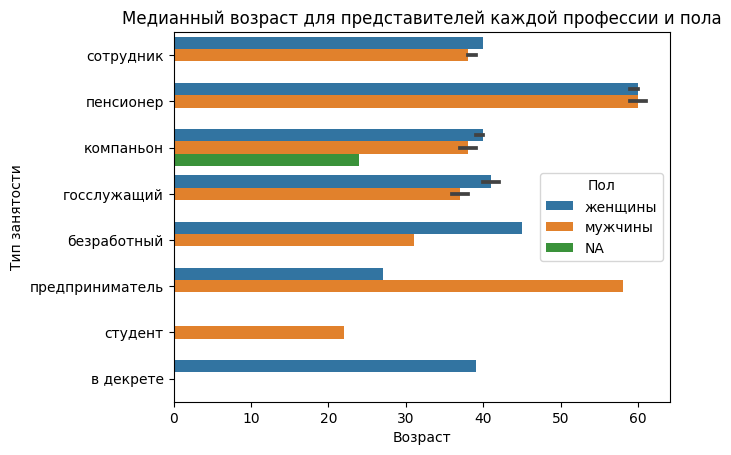

In [337]:
tmp_age = sns.barplot(x=data['dob_years'], y=data['income_type'], hue=data['gender'], estimator=np.median) # создаем график на котором отобразим медианные возраста по категориям граждан и полу
plt.xlabel('Возраст') #
plt.ylabel('Тип занятости')
plt.title('Медианный возраст для представителей каждой профессии и пола')
legend_labels, _ = tmp_age.get_legend_handles_labels() # получаем метки легенды в переменную и хендлеры в неиспользуемую переменную
plt.legend(legend_labels, ['женщины', 'мужчины', 'NA'], title='Пол')
plt.show()

Из графика видно, что категории отличаются по возрасту но внутри по полу имеются минимальные отличия. Кроме категорий предприниматель и безработный. Проверим их более точно.

In [338]:
data.query('gender=="M"').value_counts('income_type') # количество значений для мужчин

income_type
сотрудник          4315
компаньон          1887
пенсионер           698
госслужащий         385
безработный           1
предприниматель       1
студент               1
Name: count, dtype: int64

In [339]:
data.query('gender=="F"').value_counts('income_type') # количество значений для женщин

income_type
сотрудник          6804
компаньон          3197
пенсионер          3158
госслужащий        1074
безработный           1
в декрете             1
предприниматель       1
Name: count, dtype: int64

In [340]:
data['income_type'].value_counts() # общее количество значений по категориям

income_type
сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: count, dtype: int64

Из данных видно, что категория и предприниматель имеют всего пару человек, потому проще их не брать в расчет медианного значения. При заполнении нулевых значений будет опираться на более насыщенные категории.

Создадим датафрейм для создания медианных значений без нулевых.

In [341]:
data_age_nonull = data.query('dob_years!=0').dropna(axis=0) # срез датафрейма без нулевых значений и пропущенных

Вычислим медианный возраст для каждой категории

In [342]:
data_gender_median_age = data_age_nonull.groupby(['gender','income_type'])['dob_years'].median() # сгруппируем таблицу по полу и категорям со значениями медианного возраста
data_gender_median_age

gender  income_type    
F       в декрете          39.0
        госслужащий        42.0
        компаньон          40.0
        пенсионер          60.0
        предприниматель    27.0
        сотрудник          40.0
M       госслужащий        37.0
        компаньон          38.0
        пенсионер          60.0
        сотрудник          38.0
        студент            22.0
XNA     компаньон          24.0
Name: dob_years, dtype: float64

Создадим новый столбец age с новым возрастом для тех у кого ноль согласно их категории и значением из dob_years у кого он был

In [343]:
def age(row, age_dict):
    '''функция принимает строку из исходного датафрейма и словарь с новыми значениями медиан возраста.
    С помощью логического оператора отбирается из исходного датафрейма строка с нулевым значеним, затем из словаря берется по двум ключам значение медианы для необходимой категории и пола и
    возвращается в качестве ответа. Если значение уже есть в столбце dob_years, то вернется это значение'''
    if row['dob_years']==0:
        gender = row['gender']
        income_type = row['income_type']
        return age_dict[gender][income_type]
    else:
        return row['dob_years']
data['age'] = data.apply(lambda x: age(x, data_gender_median_age), axis=1).astype(int) # заменим все нулевые значения на медианные по категориям и запишем в новый столбик age
data = data.drop('dob_years', axis=1) # удалим столбец dob_years
data.head()


,children,days_employed,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age
0,1,8437.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,42
1,1,4024.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,36
2,0,5623.0,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,33
3,3,4124.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,32
4,0,14235.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,53


Проверим что за значение XNA стоит в столбце gender и много ли их

In [344]:
data.query('gender=="XNA"') # проверим количество значений и что оно из себя предствавляет

,children,days_employed,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age
10701,0,2358.0,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости,24


так как значение всего одно и логически понять пол невозможно, проше удалить эту строку

In [345]:
data.drop(data.loc[data['gender']=='XNA'].index, inplace=True) # удаление строки со значеним пола XNA

Проверим на отрицательные значения столбик total_income на отрицательные значения, так же изменим тип на целочисленный. Заменим пустные значения на медианный доход в зависимости от income_type.

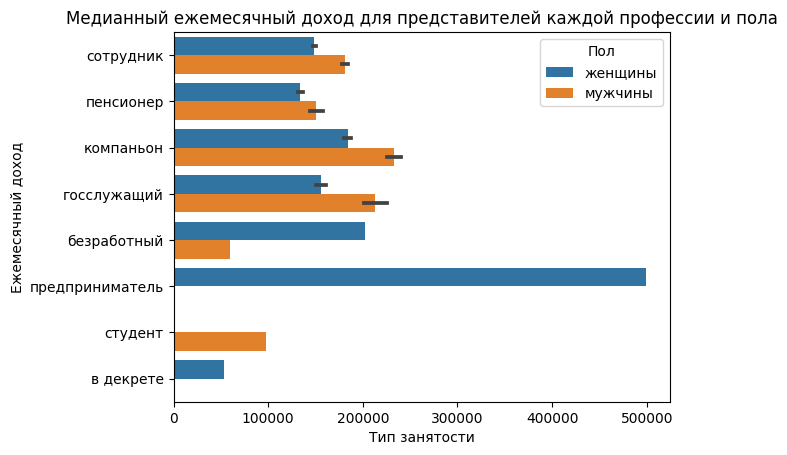

In [346]:
tmp_income = sns.barplot(x=data['total_income'], y=data['income_type'], hue=data['gender'])
plt.xlabel('Тип занятости')
plt.ylabel("Ежемесячный доход")
plt.title('Медианный ежемесячный доход для представителей каждой профессии и пола')
legend_labels, _ = tmp_income.get_legend_handles_labels()
tmp_income.legend(legend_labels, ['женщины', 'мужчины'], title='Пол')
plt.show()

Вновь видно, как и с возрастом ситуация подобна. Имеются небольшие отличия по уровню дохода мужчин и женщин. Так же категории предпренимателей так же выбивается из общей картины.

In [347]:
# проверим наличие отрицательных значений
len(data.query('total_income<0'))

0

In [348]:
# посмотрим какие представители пропущенны в столбце total_income
data[data['total_income'].isna()]['income_type'].unique()

array(['пенсионер', 'госслужащий', 'компаньон', 'сотрудник',
       'предприниматель'], dtype=object)

In [349]:
# Методом fillna + groupby + transform + median заполним пропуски в стобце total_income медианными значениями дохода для каждого пола и типа занятости.
data['total_income'] = data['total_income'].fillna(data.groupby(['gender', 'income_type'])['total_income'].transform('median'))

Из всех значений, проблема может лишь возникнуть с категорией "предприниматель", так как к этой категории присутсвует лишь по одному представителю каждого пола, и как следствие, у нас может не найтись для него нужного значения.

In [350]:
data[data['total_income'].isna()] # выведем оставшиеся незаполненве значения

,children,days_employed,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age
5936,0,1203.0,высшее,0,женат / замужем,0,M,предприниматель,0,NaN,покупка жилой недвижимости,58


In [351]:
data[data['income_type']=='предприниматель']

,children,days_employed,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age
5936,0,1203.0,высшее,0,женат / замужем,0,M,предприниматель,0,NaN,покупка жилой недвижимости,58
18697,0,520.0,высшее,0,гражданский брак,1,F,предприниматель,0,499163.144947,на проведение свадьбы,27


как и ожидалось, предприниматель мужчина оказался не заполнен. Заполним его доход тем же числом, что и предприниматель женщины.

In [352]:
data.loc[5936, 'total_income']=data.loc[18697, 'total_income']

In [353]:
data[data['income_type']=='предприниматель']

,children,days_employed,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age
5936,0,1203.0,высшее,0,женат / замужем,0,M,предприниматель,0,499163.144947,покупка жилой недвижимости,58
18697,0,520.0,высшее,0,гражданский брак,1,F,предприниматель,0,499163.144947,на проведение свадьбы,27


In [354]:
# замениим тип данных столбца total_income float на int
data['total_income']= data['total_income'].astype('int')
data.head()

,children,days_employed,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age
0,1,8437.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,42
1,1,4024.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,36
2,0,5623.0,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,33
3,3,4124.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,32
4,0,14235.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,53


In [355]:
# преобразуем столбик gender в категориальный тип данных
data['gender'] = data['gender'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21524 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   children          21524 non-null  int64   
 1   days_employed     21522 non-null  float64 
 2   education         21524 non-null  object  
 3   education_id      21524 non-null  int64   
 4   family_status     21524 non-null  object  
 5   family_status_id  21524 non-null  int64   
 6   gender            21524 non-null  category
 7   income_type       21524 non-null  object  
 8   debt              21524 non-null  int64   
 9   total_income      21524 non-null  int32   
 10  purpose           21524 non-null  object  
 11  age               21524 non-null  int32   
dtypes: category(1), float64(1), int32(2), int64(4), object(4)
memory usage: 2.3+ MB


### Шаг 2.3. Удаление дубликатов.

Перед чисткой дубликатов, необходимо обработать неявные дубликаты, такие как строки, записанные с использованием разного регистра в столбцах education, family_status. Для этого можно использовать метод str.lower(), который приведет все строки в столбце к нижнему регистру.

In [356]:
data['education'] = data['education'].str.lower() # приведем столбик education к нижниму регистру
data['family_status'] = data['family_status'].str.lower() # приведем столбик family_status к нижниму регистру

In [357]:
data.duplicated().sum() # проверим количество дубликатов

71

In [358]:
# удалим явные дубликаты и проверим их количество
data = data.drop_duplicates().reset_index(drop=True) 
data.duplicated().sum()


0

### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

In [359]:
# достаем из датафрейма data два столбца education и family_status с id столбцами для дольнейшего анализа
# удаляем столбцы  education и family_status из исходного датафрейма
education_group = data[['education','education_id']].drop_duplicates()
display(education_group['education'].unique())
del data['education']
family_status_group = data[['family_status','family_status_id']].drop_duplicates().reset_index()
display(family_status_group)
display(family_status_group['family_status'].unique())
del data['family_status']

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

,index,family_status,family_status_id
0,0,женат / замужем,0
1,4,гражданский брак,1
2,18,вдовец / вдова,2
3,19,в разводе,3
4,24,не женат / не замужем,4


array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'не женат / не замужем'], dtype=object)

### Шаг 2.6. Категоризация дохода.

In [360]:
def total_income_category(row):
    """
    Присваивает индекс клиенту банка в зависимости от финансового 
    дохода клиента: 0–30000 — 'E'; 30001–50000 — 'D'; 50001–200000 — 'C';
    200001–1000000 — 'B'; 1000001 и выше — 'A'.
    """
    income = row['total_income']
    if income<=30000:
        return 'E'
    elif 30001<=income<=50000:
        return 'D'
    elif 50001<=income<=200000:
        return 'C'
    elif 200001<=income<=1000000:
        return 'B'
    else:
        return 'A'

In [361]:
# добавим новый столбик с присвоенными категориями по уровню достатка 
# с помощью фцункции total_income_category
data['total_income_category'] = data.apply(total_income_category, axis=1).astype('category')

### Шаг 2.7. Категоризация целей кредита.

In [362]:
# выведем список уникальных значений в столбце purpose (цель кредита)
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Основные ключевые слова, которые встречаются: образование, автомобиль, свадьба, недвижимость

In [363]:
def purpose_category(row):
    """
    Функция возвращает значение из 4 категорий: 'операции с автомобилем',
'операции с недвижимостью', 'проведение свадьбы', 'получение образования'.
Ориентируясь на ключевые уникальные слова в столбце purpose 
    """
    purpose = row['purpose']
    auto = 'автомоб'
    house =['жил', 'недвижим']
    wedding = 'свадьб'
    education = 'образов'
    if auto in purpose:
        return 'операции с автомобилем'
    elif house[0] in purpose or house[1] in purpose:
        return 'операции с недвижимостью'
    elif wedding in purpose:
        return 'проведение свадьбы'
    elif education in purpose:
        return 'получение образования'

In [364]:
#проверка функции purpose_category
# test_data = ['покупка жилья', 'приобретение автомобиля',
#        'дополнительное образование', 'сыграть свадьбу',
#        'операции с жильем', 'образование', 'на проведение свадьбы',
#        'покупка жилья для семьи', 'покупка недвижимости',
#        'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
#        'строительство собственной недвижимости', 'недвижимость',
#        'строительство недвижимости', 'на покупку подержанного автомобиля',
#        'на покупку своего автомобиля',
#        'операции с коммерческой недвижимостью',
#        'строительство жилой недвижимости', 'жилье',
#        'операции со своей недвижимостью', 'автомобили',
#        'заняться образованием', 'сделка с подержанным автомобилем',
#        'получение образования', 'автомобиль', 'свадьба',
#        'получение дополнительного образования', 'покупка своего жилья',
#        'операции с недвижимостью', 'получение высшего образования',
#        'свой автомобиль', 'сделка с автомобилем',
#        'профильное образование', 'высшее образование',
#        'покупка жилья для сдачи', 'на покупку автомобиля', 'ремонт жилью',
#        'заняться высшим образованием']
# test_columns = ['purpose']
# row = pd.DataFrame(test_data, columns=test_columns)
# row['test'] = row.apply(purpose_category,axis=1)
# row


In [365]:
# создание столбца с категоризацией по виду категории кредита
data['purpose_category'] = data.apply(purpose_category, axis=1)

In [366]:
# Создадим отдельную таблицу категорий назначения кредита и столбик в data purpose_category_id
purpose_group = {data['purpose_category'].unique()[i]: i for i in range(len(data['purpose_category'].unique()))}
purpose_group

{'операции с недвижимостью': 0,
 'операции с автомобилем': 1,
 'получение образования': 2,
 'проведение свадьбы': 3}

In [367]:
#  создадим столбец в датафрейме с соответствующим id
data['purpose_category_id'] = data['purpose_category'].map(lambda x: purpose_group[x])
data[['purpose', 'purpose_category', 'purpose_category_id']].head()

,purpose,purpose_category,purpose_category_id
0,покупка жилья,операции с недвижимостью,0
1,приобретение автомобиля,операции с автомобилем,1
2,покупка жилья,операции с недвижимостью,0
3,дополнительное образование,получение образования,2
4,сыграть свадьбу,проведение свадьбы,3


In [368]:
# для удобства преобразуем purpoce_group в датафрейм и удалим лишний столбец из датафрейма data
purpose_group = pd.DataFrame(data=purpose_group, index=['purpose_category_id']).T.reset_index().rename(columns={'index':'purpose_category'}) # T меняем местами столбцы и строки (транспонирование)
data = data.drop(['purpose', 'purpose_category'], axis=1) # удаляем лишние столбцы 'purpose', 'purpose_category'
purpose_group

,purpose_category,purpose_category_id
0,операции с недвижимостью,0
1,операции с автомобилем,1
2,получение образования,2
3,проведение свадьбы,3


### Ответы на вопросы.

##### Вопрос 1: Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [369]:
# группируем с условием по id возврата/задолжности кредита в два разных датафрейма по разным id
children_1 = data[data['debt']==1].groupby('children').size().reset_index(name='has_a_debt')
children_0 = data[data['debt']==0].groupby('children').size().reset_index(name='has_no_debt')
# объединяем по общему столбцу children эти два датафрейма для получения общего с величинами количества возвратов и задолжностей
children = children_1.merge(children_0, on='children')
# вычисляем процент возврата в зависимотси от наличия ребенка в семье, округляем до сотый для удобства 
children['share_has_a_debt']= (children['has_a_debt']/(children['has_no_debt']+children['has_a_debt'])*100).round(2)
children['share_has_no_debt']= (children['has_no_debt']/(children['has_no_debt']+children['has_a_debt'])*100).round(2)
children

,children,has_a_debt,has_no_debt,share_has_a_debt,share_has_no_debt
0,0,1063,13027,7.54,92.46
1,1,445,4410,9.17,90.83
2,2,202,1926,9.49,90.51
3,3,27,303,8.18,91.82
4,4,4,37,9.76,90.24


In [370]:
# делаем все тоже самое, выводим зависимость в процентах, но быстрее и проще с помощью сводных таблиц
children_debt = pd.crosstab(index= data['debt'], columns=data['children'], normalize='columns', margins=True)
children_debt

children,0,1,2,3,4,5,All
debt,,,,,,,
0,0.924556,0.908342,0.905075,0.918182,0.902439,1.0,0.918846
1,0.075444,0.091658,0.094925,0.081818,0.097561,0.0,0.081154


##### Вывод 1:

На основе представленных данных, можно сделать вывод о том, что зависимость от количества детей оказывает влияние на невозврат кредита в срок. Доля должников в группе без детей всего 7,5%, а в греппе с 2 детьми 9,5%.

Отобразим все это на графике для наглядности.

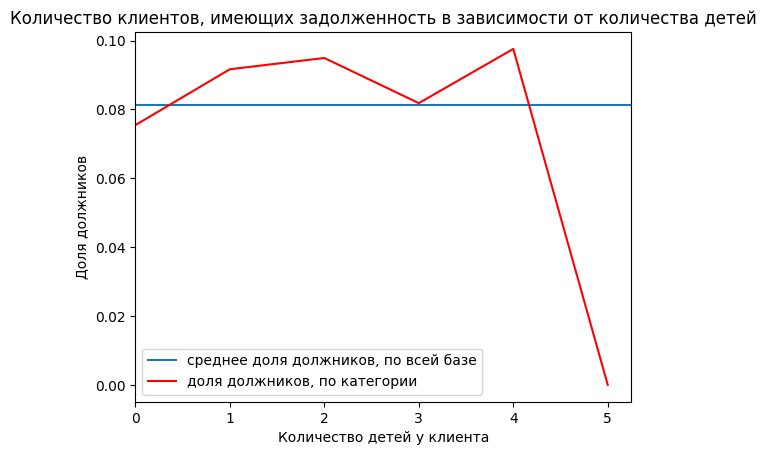

In [371]:
fig, ax= plt.subplots() # создаем новый объекс Figure и Axes, область для рисования

ax.axhline(y=children_debt.iloc[1,6], label = 'среднее доля должников, по всей базе') # строим график в виде линии для средней доли должников
ax.plot(children_debt.iloc[1,:6], 'r', label='доля должников, по категории') # строим график в виде линии для должников по группам
plt.legend() # добавляем легенду
plt.xlim(left=0) # устанавливаем левую границу по X от 0
plt.xlabel('Количество детей у клиента')
plt.ylabel('Доля должников') 
ax.set_title('Количество клиентов, имеющих задолженность в зависимости от количества детей')
plt.show()

Наибольшее число должников приходится на заемщиков с 2 и 4 детьми. В категоии 5 детей видно какую-то анамалию.

In [372]:
data['children'].value_counts()

children
0    14090
1     4855
2     2128
3      330
4       41
5        9
Name: count, dtype: int64

Заемщиков с 5 детьми всего 9 человек, что не является показателем, можно эту аномалию проигнорировать. Так же можно заметить что 3 и 4 ребенка имеют не такая большая доля заемщиков, что тоже не является большим показателем. Но судя по всем данным наблюдается растущий тренд.

Вывод:

Зависимость между количество детей и возвратом кредита присутствует. Наибольшее число невозвратов наблюдается у заемщиков с 2 и 4 детьми. Можно сделать заключение, что чем больше детей, тем больше вероятность невозврата.

##### Вопрос 2: Есть ли зависимость между семейным положением и возвратом кредита в срок?


In [373]:
family_debt = pd.crosstab(index=data['debt'], columns=data['family_status_id'], margins=True, normalize='columns') # создадим сводную таблицу 
display(family_status_group)
family_debt = family_debt.rename(columns=dict(zip(family_debt.columns, family_status_group['family_status']))) # заменим значение id на наглядный статус
family_debt

,index,family_status,family_status_id
0,0,женат / замужем,0
1,4,гражданский брак,1
2,18,вдовец / вдова,2
3,19,в разводе,3
4,24,не женат / не замужем,4


family_status_id,женат / замужем,гражданский брак,вдовец / вдова,в разводе,не женат / не замужем,All
debt,,,,,,
0,0.924548,0.906506,0.934307,0.92887,0.902491,0.918846
1,0.075452,0.093494,0.065693,0.07113,0.097509,0.081154


Из данных видно, что наименьшее число невозвратов имеют вдовцы\вдовы, а так же в разводе. А наибольшее значение не женатые\не замужние люди.

C:\Users\user\AppData\Local\Temp\ipykernel_15120\4266087275.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(family_debt.columns, rotation=15) # поворачиваем значения оси Х на 15 градусов


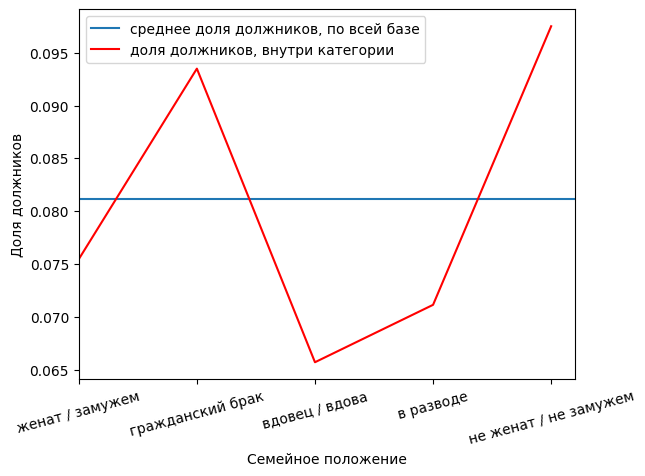

In [374]:
fig, ax = plt.subplots() # создаем поле 
ax.axhline(y=family_debt.iloc[1,5], label='среднее доля должников, по всей базе') # создаем линию среднего невозврата
ax.plot(family_debt.iloc[1,:5], 'r', label='доля должников, внутри категории') # создаем кривую невозврата
plt.legend()
plt.xlim(left=0)
plt.xlabel('Семейное положение')
plt.ylabel('Доля должников')
ax.set_xticklabels(family_debt.columns, rotation=15) # поворачиваем значения оси Х на 15 градусов
plt.show()

In [375]:
# проверим количество значений в столбце family статус, чтобы убедиться в отсутствии аномалий
data['family_status_id'].value_counts()


family_status_id
0    12339
1     4150
4     2810
3     1195
2      959
Name: count, dtype: int64

Значений достаточно для анализа

Вывод: 

На основе представленных данных, можно сделать вывод о том, что семейное оказывает влияние на возврат кредита в срок. 
Наибольшая доля должников наблюдается среди клиентов с семейным статусом "гражданский брак" и "не женат / не замужем"
Наименьшая доля должников наблюдается среди клиентов с семейным статусом "вдовец / вдова"

##### Вопрос 3: Есть ли зависимость между уровнем дохода и возвратом кредита в срок?


In [376]:
# вспомним какие есть категории
help(total_income_category)

Help on function total_income_category in module __main__:

total_income_category(row)
    Присваивает индекс клиенту банка в зависимости от финансового 
    дохода клиента: 0–30000 — 'E'; 30001–50000 — 'D'; 50001–200000 — 'C';
    200001–1000000 — 'B'; 1000001 и выше — 'A'.



In [377]:
income_debt = pd.crosstab(index=data['debt'], columns=data['total_income_category'], margins=True, normalize='columns') # создадим сводную таблицу 
income_debt

total_income_category,A,B,C,D,E,All
debt,,,,,,
0,0.92,0.929379,0.91508,0.94,0.909091,0.918846
1,0.08,0.070621,0.08492,0.06,0.090909,0.081154


In [378]:
data['total_income_category'].value_counts() # узнаем количество значений по категориям для оценки значений невозврата на аномалии

total_income_category
C    16015
B     5041
D      350
A       25
E       22
Name: count, dtype: int64

C:\Users\user\AppData\Local\Temp\ipykernel_15120\4149914961.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(income_debt.columns, rotation=15)


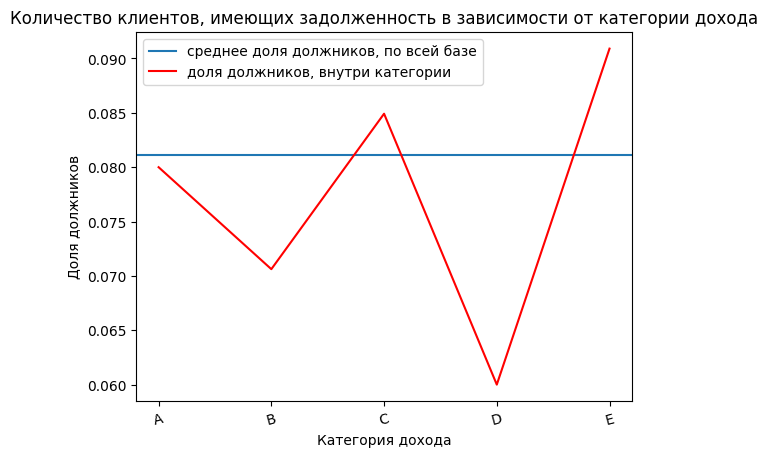

In [386]:
# для наглядности построим график
fig, ax = plt.subplots()

ax.axhline(y=income_debt.iloc[1,5], label='среднее доля должников, по всей базе') #среднее количество должников для все базы клиентов
ax.plot(income_debt.iloc[1,:5], 'r', label='доля должников, внутри категории') #доля должников в каждой группе клиентов

plt.legend()
plt.xlabel('Категория дохода')
plt.ylabel('Доля должников')
ax.set_title('Количество клиентов, имеющих задолженность в зависимости от категории дохода')
ax.set_xticklabels(income_debt.columns, rotation=15)
plt.show()

Вывод:

Наибольшая доля должников наблюдается в категории людей с доходом 0-30000, в то время как наименьшая доля должников находится в группе людей с доходом 30000-50000.

Зависимость между уровнем дохода и возвратом кредита в срок практически присутствует.


##### Вопрос 4: Как разные цели кредита влияют на его возврат в срок?


In [382]:
purpose_group

,purpose_category,purpose_category_id
0,операции с недвижимостью,0
1,операции с автомобилем,1
2,получение образования,2
3,проведение свадьбы,3


In [381]:
purpose_debt = pd.crosstab(index=data['debt'], columns=data['purpose_category_id'], normalize='columns', margins=True)
purpose_debt = purpose_debt.rename(columns=dict(zip(purpose_debt.columns, purpose_group['purpose_category']))) 
purpose_debt

purpose_category_id,операции с недвижимостью,операции с автомобилем,получение образования,проведение свадьбы,All
debt,,,,,
0,0.92766,0.90641,0.9078,0.919966,0.918846
1,0.07234,0.09359,0.0922,0.080034,0.081154


In [383]:
data['purpose_category_id'].value_counts()

purpose_category_id
0    10810
1     4306
2     4013
3     2324
Name: count, dtype: int64

значений в каждой категории достаточно для объективного анализа

C:\Users\user\AppData\Local\Temp\ipykernel_15120\3341939488.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(purpose_debt.columns, rotation=15)


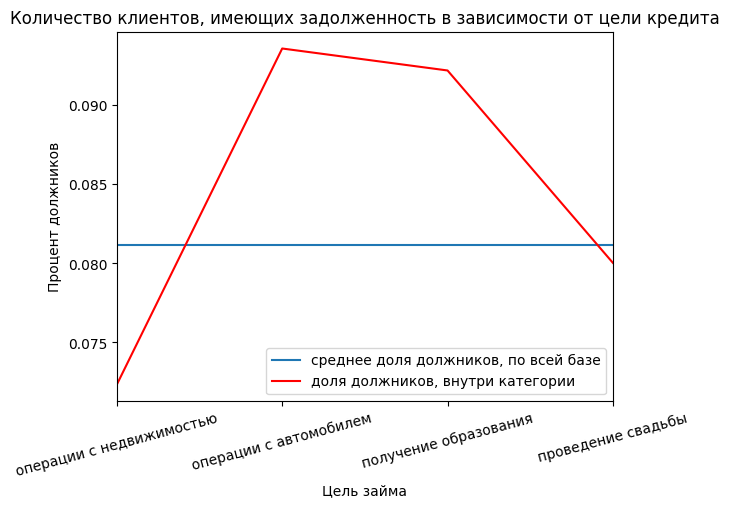

In [385]:
fig, ax = plt.subplots()

ax.axhline(y=purpose_debt.iloc[1, 4], 
           label='среднее доля должников, по всей базе') #среднее количество должников для все базы клиентов
ax.plot(purpose_debt.iloc[1, :4], 'r', 
    label='доля должников, внутри категории'); #доля должников в каждой группе клиентов

plt.legend()
plt.xlim(left=0, right=3)
plt.xlabel('Цель займа')
plt.ylabel('Процент должников')
ax.set_title('Количество клиентов, имеющих задолженность в зависимости от цели кредита')
ax.set_xticklabels(purpose_debt.columns, rotation=15)
plt.show()

На графике наглядно видно, что наибольшая доля людей с задолженность находится в группах с операциями с автомобилями и образованием. В то же время наименьшая доля людей не вернувших долг в срок находится в группе операции с недвижимостью

Вывод:

Цели кредита влияют на срок его возврата.
При этом, наибольшая доля людей не вернувших займ в срок находится среди людей, которые брали кредит на цели покупку автомобиля и образование, а наименьшая доля - среди людей, которые брали кредит на недвижимость

## Общий вывод:

В ходы работы над предобработкой данных были проделаны следующие шаги:

* Были выялвены и устранены ошибки в данных
* Были выявленны и удалены явные и неявные дубликаты
* Был оптимизирован объем, занимаемый датафремом, за счет оптимизации формата, в котором хранятся переменные таблицы, а также за счет вынесения одинаковых посмыслу признаков в отдельные датафреймы-словари.
* Были заполнены пропуски в данных.
* Была произведена категоризация признака purpose, в результате чего были выделены 4 категории цели взятия кредита, а именно: получение образования, операции с автомобилем, проведение свадьбы, операции с недвижимостью
* Была произведена категоризация клиентов по уровню ежемесячного дохода

В ходе аналитической работы, были проверены 4 гипотезы, а именно:

1. Есть зависимость между наличием детей и возвратом кредита в срок
2. Есть зависимость между семейным положением и возвратом кредита в срок
3. Есть зависимость между уровнем дохода и возвратом кредита в срок
4. Разные цели кредита влияют на его возврат в срок.

В результате, все 4 гипотезы были подтверждены:

1. Есть зависимость между наличием детей и возвратом кредита в срок. Чем больше детей, тем выше вероятность того, что клиент просрочит кредит
2. Есть зависимость между семейным положением и возвратом кредита в срок. Человек с большей вероятностью задержит возврат кредита, если он относится к категории клиентов с семейным статусом "гражданский брак" и "не женат / не замужем". Меньшая вероятность задержки возврата кредита наблюдается у клиентов с семейным статусом "вдовец / вдова"
3. Есть зависимость между уровнем дохода и возвратом кредита в срок. Наибольшая доля должников наблюдается в категории людей с доходом 0-30000, в то время как наименьшая доля должников находится в группе людей с доходом 30000-50000.
4. Разные цели кредита влияют на его возврат в срок. Наибольшая доля клиентов, которые просрочили кредит находится среди клиентов, которые взяли кредит на "операции с автомобилем" и на оплату "получение образования", наименьшая - среди людей, которые брали кредит для проведения операций с недвижимостью